## Plot Experiment 2

In [ ]:
import pickle
import numpy as np 
import re 
from pathlib import Path
import pandas as pd
import json 
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from src import util_analysis 

import re 

In [64]:
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("final_figures/figure_2")
fig_out_dir.mkdir(exist_ok=True, parents=True)

In [65]:
results_dir = Path('final_results_dir')

results = pd.read_csv(results_dir / "experiment_2_df_for_plot_and_stats.csv")



In [66]:
results.group.unique()

array(['Humans (N = 90)', 'Early-only model', 'Late-only model',
       'Feature-gain model', 'Baseline CNN'], dtype=object)

## Run statistics 

In [67]:
import scipy.stats as stats

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

## Cohen's d for paired samples
def cohend_paired(d1, d2):
    # is difference of means, divided by standard deviation of differences
    return (np.mean(d1) - np.mean(d2))/ np.std(d1 - d2, ddof=1)


#### Run with pingouin to make sure result is stable

In [68]:
from pingouin import rm_anova

for_stats = results[results.group.str.contains('Human')].copy()
for_stats = for_stats[(for_stats.target_harmonicity == for_stats.distractor_harmonicity) | (for_stats.distractor_harmonicity == 'No Distractor')].copy()
# for_stats = for_stats[for_stats.attended_stream != 'Distractor']

human_rm_anova_table = rm_anova(data=for_stats, dv='hits', subject='id_subject', within=['target_harmonicity', 'attended_stream'], effsize='np2')
print("ANOVA for humans")
human_rm_anova_table



ANOVA for humans


/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,target_harmonicity,1.282008,2,178,0.641004,61.417870,5.200689e-21,1.478091e-20,0.408315,0.975433
1,attended_stream,66.874074,2,178,33.437037,894.890110,1.328812e-93,3.835036e-70,0.909543,0.741450
2,target_harmonicity * attended_stream,1.970831,4,356,0.492708,39.356282,2.742046e-27,4.491045e-15,0.306617,0.507799


In [69]:
## Run model anova 

for_stats = results[(results.target_harmonicity == results.distractor_harmonicity) | (results.distractor_harmonicity == 'No Distractor')].copy()
for_stats = for_stats[(for_stats.group.str.contains("Feature")) & (for_stats.attended_stream != 'Distractor')]

rm_anova_table = rm_anova(data=for_stats, dv='hits', subject='model', within=['target_harmonicity', 'attended_stream'], effsize='np2')
print("ANOVA for Feature-gain models")
rm_anova_table

ANOVA for Feature-gain models


/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,target_harmonicity,0.142167,2,18,0.071083,260.724530,5.127416e-14,7.332548e-09,0.966633,0.574539
1,attended_stream,2.270843,1,9,2.270843,3271.477551,7.684967e-13,7.684967e-13,0.997256,1.000000
2,target_harmonicity * attended_stream,0.029979,2,18,0.014989,116.150546,5.143845e-11,5.620524e-08,0.928087,0.666809


In [70]:
data_to_measure = results[(results.group.str.contains('Feature')) & (results.attended_stream != 'Distractor')]
data_to_measure = data_to_measure[(data_to_measure.target_harmonicity == data_to_measure.distractor_harmonicity) | (data_to_measure.distractor_harmonicity == 'No Distractor')]


### Run t-tests

In [75]:
ttest_results = []


human_for_stats = results[results.attended_stream == 'Single sentence']

harmonic_hits = human_for_stats[human_for_stats.target_harmonicity == 'Harmonic'].hits.values
inharmonic_hits = human_for_stats[human_for_stats.target_harmonicity == 'Inharmonic'].hits.values
whispered_hits = human_for_stats[human_for_stats.target_harmonicity == 'Whispered'].hits.values

## ttest harmonic vs inharmonic
result  = stats.ttest_rel(harmonic_hits, inharmonic_hits)
harm_inharm_d = cohend_paired(harmonic_hits, inharmonic_hits)

print(f"Harmonic vs Inharmonic single sentence ttest: t({result.df}) = {result.statistic:.2f}, p = {result.pvalue:.2f} d = {harm_inharm_d:.2f} ")
record = {'group': 'Humans', 'stream': 'Single sentence', 'comparison': 'Harmonic vs Inharmonic', 't': result.statistic, 'p': result.pvalue, 'd': harm_inharm_d}
ttest_results.append(record)

## ttest harmonic vs whispered
result= stats.ttest_rel(harmonic_hits, whispered_hits)  
harm_whisp_d = cohend_paired(harmonic_hits, whispered_hits)

print(f"Harmonic vs Whispered single sentence ttest: t({result.df}) = {result.statistic:.2f}, p = {result.pvalue:.2f} d = {harm_whisp_d:.2f}")
print('\n')
record = {'group': 'Humans', 'stream': 'Single sentence', 'comparison': 'Harmonic vs Whispered', 't': result.statistic, 'p': result.pvalue, 'd': harm_whisp_d}
ttest_results.append(record)


data_to_measure = results[results.group.str.contains('Human')]
data_to_measure = data_to_measure[(data_to_measure.target_harmonicity == data_to_measure.distractor_harmonicity) | (data_to_measure.distractor_harmonicity == 'No Distractor')]
data_to_measure = data_to_measure[data_to_measure.attended_stream == 'Target']

harmonic_hits = data_to_measure[data_to_measure.target_harmonicity == 'Harmonic'].hits.values
inharmonic_hits = data_to_measure[data_to_measure.target_harmonicity == 'Inharmonic'].hits.values
whispered_hits = data_to_measure[data_to_measure.target_harmonicity == 'Whispered'].hits.values

## ttest harmonic vs inharmonic
harm_inharm_result  = stats.ttest_rel(harmonic_hits, inharmonic_hits)
harm_inharm_cohens_d = cohend_paired(harmonic_hits, inharmonic_hits)
print(f"Harmonic vs Inharmonic target stream ttest: t({harm_inharm_result.df}) = {harm_inharm_result.statistic:.3f}, p = {harm_inharm_result.pvalue:.4f}, d = {harm_inharm_cohens_d:.2f}")
record = {'group': 'Humans', 'stream': 'Target', 'comparison': 'Harmonic vs Inharmonic', 't': harm_inharm_result.statistic, 'p': harm_inharm_result.pvalue, 'd': harm_inharm_cohens_d}
ttest_results.append(record)

## ttest harmonic vs whispered
harm_whispered_result= stats.ttest_rel(harmonic_hits, whispered_hits)
harm_whispered_cohens_d = cohend_paired(harmonic_hits, whispered_hits)
print(f"Harmonic vs Whispered target stream ttest: t({harm_whispered_result.df}) = {harm_whispered_result.statistic:.3f}, p = {harm_whispered_result.pvalue:.4f}, d = {harm_whispered_cohens_d:.2f}")
record = {'group': 'Humans', 'stream': 'Target', 'comparison': 'Harmonic vs Whispered', 't': harm_whispered_result.statistic, 'p': harm_whispered_result.pvalue, 'd': harm_whispered_cohens_d}
ttest_results.append(record)

Harmonic vs Inharmonic single sentence ttest: t(102) = 0.18, p = 0.86 d = 0.02 
Harmonic vs Whispered single sentence ttest: t(102) = 2.47, p = 0.02 d = 0.24


Harmonic vs Inharmonic target stream ttest: t(89) = 4.413, p = 0.0000, d = 0.47
Harmonic vs Whispered target stream ttest: t(89) = 13.290, p = 0.0000, d = 1.40


In [76]:
### Add model results to ttest results

for group in ['Feature-gain model',]: # 'Early-only model', 'Late-only model', 'Baseline model']:
    data_to_measure = results[(results.group == group) & (results.attended_stream != 'Distractor')]
    data_to_measure = data_to_measure[(data_to_measure.target_harmonicity == data_to_measure.distractor_harmonicity) | (data_to_measure.distractor_harmonicity == 'No Distractor')]
    print(f"Model: {group}")
    for stream in ['Single sentence', 'Target']:

        if stream == 'Single sentence':
            harmonic_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Harmonic') & (data_to_measure.distractor_harmonicity == 'No Distractor')].hits.values
            inharmonic_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Inharmonic') & (data_to_measure.distractor_harmonicity == 'No Distractor')].hits.values
            whispered_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Whispered') & (data_to_measure.distractor_harmonicity == 'No Distractor')].hits.values

        elif stream == 'Target':
            harmonic_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Harmonic') & (data_to_measure.distractor_harmonicity == 'Harmonic')].hits.values
            inharmonic_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Inharmonic') & (data_to_measure.distractor_harmonicity == 'Inharmonic')].hits.values
            whispered_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Whispered') & (data_to_measure.distractor_harmonicity == 'Whispered')].hits.values


        ## ttest harmonic vs inharmonic
        harm_inharm_result  = stats.ttest_rel(harmonic_hits, inharmonic_hits)
        harm_inharm_cohens_d = cohend_paired(harmonic_hits, inharmonic_hits)
        print(f"Harmonic vs Inharmonic {stream} stream ttest: t({harm_inharm_result.df}) = {harm_inharm_result.statistic:.3f}, p = {harm_inharm_result.pvalue:.4f}, d = {harm_inharm_cohens_d:.3f}")
        record = {'group': group, 'stream': stream, 'comparison': 'Harmonic vs Inharmonic', 't': harm_inharm_result.statistic, 'p': harm_inharm_result.pvalue, 'd': harm_inharm_cohens_d}
        ttest_results.append(record)

        ## ttest harmonic vs whispered
        harm_whispered_result= stats.ttest_rel(harmonic_hits, whispered_hits)
        harm_whispered_cohens_d = cohend_paired(harmonic_hits, whispered_hits)
        print(f"Harmonic vs Whispered {stream} stream ttest: t({harm_whispered_result.df}) = {harm_whispered_result.statistic:.3f}, p = {harm_whispered_result.pvalue:.4f}, d = {harm_whispered_cohens_d:.3f}")
        record = {'group': group, 'stream': stream, 'comparison': 'Harmonic vs Whispered', 't': harm_whispered_result.statistic, 'p': harm_whispered_result.pvalue, 'd': harm_whispered_cohens_d}
        ttest_results.append(record)
    print('\n')



Model: Feature-gain model
Harmonic vs Inharmonic Single sentence stream ttest: t(9) = -0.778, p = 0.4566, d = -0.246
Harmonic vs Whispered Single sentence stream ttest: t(9) = 12.442, p = 0.0000, d = 3.934
Harmonic vs Inharmonic Target stream ttest: t(9) = 5.752, p = 0.0003, d = 1.819
Harmonic vs Whispered Target stream ttest: t(9) = 15.142, p = 0.0000, d = 4.788




In [77]:
ttest_df = pd.DataFrame.from_records(ttest_results)
ttest_df

,group,stream,comparison,t,p,d
0,Humans,Single sentence,Harmonic vs Inharmonic,0.176994,8.598641e-01,0.017440
1,Humans,Single sentence,Harmonic vs Whispered,2.467731,1.526125e-02,0.243153
2,Humans,Target,Harmonic vs Inharmonic,4.413069,2.850901e-05,0.465178
3,Humans,Target,Harmonic vs Whispered,13.290222,7.581978e-23,1.400912
4,Feature-gain model,Single sentence,Harmonic vs Inharmonic,-0.777793,4.566493e-01,-0.245960
5,Feature-gain model,Single sentence,Harmonic vs Whispered,12.441855,5.655375e-07,3.934460
6,Feature-gain model,Target,Harmonic vs Inharmonic,5.752076,2.755750e-04,1.818966
7,Feature-gain model,Target,Harmonic vs Whispered,15.141531,1.039715e-07,4.788172


# Plot with stats 

Humans
Harmonic vs Inharmonic
Target
Humans
Harmonic vs Whispered
Target
Feature-gain model
Harmonic vs Inharmonic
Target
Feature-gain model
Harmonic vs Whispered
Target


/tmp/ipykernel_3492711/3011718878.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
/tmp/ipykernel_3492711/3011718878.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')


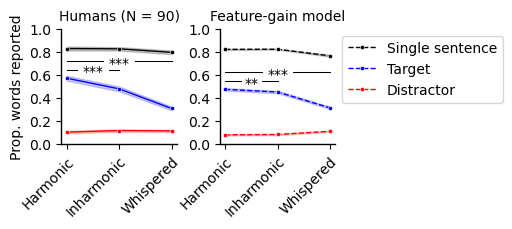

In [79]:
# def draw_stats_bar(ax, x1, x2, y, h, th=0.025, lw=1.5, col='k', fontsize=10):
#     ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c=col)
#     # edit so star is in middle of bar
#     ax.text((x1+x2)*.5, y+ th, "*", ha='center', va='center', color=col, fontsize=fontsize)

def draw_stats_bar(ax, x1, x2, y, h, text, th=0.025, lw=1.5, col='k', fontsize=10, text_gap=0.02):
    # Calculate the position of the text
    text_x = (x1 + x2) * 0.5
    text_y = y + th
    
    # Calculate the gap around the text
    gap_half_width = text_gap * len(text) # * (x2 - x1) * 0.5
    
    # Draw the left part of the bar
    ax.plot([x1, x1, text_x - gap_half_width], [y, y + h, y + h], lw=lw, c=col)
    
    # Draw the right part of the bar
    ax.plot([text_x + gap_half_width, x2, x2], [y + h, y + h, y], lw=lw, c=col)
    
    # Draw the text in the middle of the bar
    ax.text(text_x, y-0.02, text, ha='center', va='center', color=col, fontsize=fontsize)

group_order = ['Humans (N = 90)',
            'Feature-gain model',
            ]

groups_to_plot = group_order
n_models = len(groups_to_plot)

to_plot = results[results.group.isin(groups_to_plot)]
to_plot = to_plot[(to_plot.target_harmonicity == to_plot.distractor_harmonicity) | (to_plot.distractor_harmonicity == 'No Distractor')]
no_dist_IXS = to_plot[to_plot.distractor_harmonicity == 'No Distractor'].index.values
to_plot.loc[no_dist_IXS, 'distractor_harmonicity'] = to_plot.loc[no_dist_IXS, 'target_harmonicity'] 
to_plot =to_plot[to_plot.distractor_harmonicity != 'No Distractor']

hues = ['k', 'b', 'r']
hue_order = ['Single sentence', 'Target', 'Distractor']

palette = {'Target': 'b', 'Distractor': 'r', 'Single sentence': 'k'}

fontsize=10
tick_fontsize = 10
err_band_alpha = 0.2

yticks = np.linspace(0,1,6).round(1)

xtick_labels = to_plot.distractor_harmonicity.unique()
xticks = np.arange(len(xtick_labels))
ratio = 1.0 
line_thickness = 1

aspect = 1.5
fig, axs = plt.subplots(1, n_models, figsize=((aspect) * (n_models + .5), aspect ))


for ax, model in zip(axs, group_order):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='distractor_harmonicity', y='hits', 
                hue = 'attended_stream', hue_order=hue_order,
                palette=hues,
                ax=ax,
                errorbar=('se', 1), err_style='band', err_kws={'alpha':err_band_alpha},
                marker='.', 
                 )
    ax.set_title(model, fontsize=fontsize)
    ax.set_xlabel('')
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != group_order[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')


## Add p-values to plot

# set up x and y positions for p-value text
x_coord_dict = {'Harmonic_Inharmonic': {'x1': 0, 'x2': 1},
                'Harmonic_Whispered': {'x1': 0, 'x2': 2},
                'Inharmonic_Whispered': {'x1': 1, 'x2': 2}}

# get y_pos for p-value text for target stream from data
group_max = to_plot[(to_plot.attended_stream == 'Target') & (to_plot.distractor_harmonicity == 'Harmonic')].groupby(['group']).hits.mean() + 0.0
inharmonic_max = to_plot[(to_plot.attended_stream == 'Target') & (to_plot.distractor_harmonicity == 'Inharmonic')].groupby(['group']).hits.mean() + 0.0
h = 0.025
ver_shift_increment = 0.075

for ax, model in zip(axs, groups_to_plot):
    if "Humans" in model:
        model_str = "Humans"
    else:
        model_str = model
    for stream in to_plot.attended_stream.unique():
        if stream != 'Target':
            continue
        for h_shift, harm_combo in enumerate(['Harmonic_Inharmonic', "Harmonic_Whispered"]):
            #get lead condition from str for x coordinate position
            first_cond, second_cond = harm_combo.split('_')
            cond_str = f"{first_cond} vs {second_cond}"
            print(model_str)
            print(cond_str)
            print(stream)

            p_val = ttest_df[(ttest_df.comparison == cond_str) & (ttest_df.group == model_str) & (ttest_df.stream == stream)].p.item()
            if p_val < 0.05:
                text = "*"
            if p_val < 0.001:
                text = "**"
            if p_val < 0.0001:
                text = "***"
            x1 = x_coord_dict[harm_combo]['x1']
            x2 = x_coord_dict[harm_combo]['x2']
            ver_shift = ver_shift_increment * (h_shift + 1) 
            if harm_combo == 'Inharmonic_Whispered':
                y = inharmonic_max[model] + ver_shift_increment
            else:
                y = group_max[model] + ver_shift
            draw_stats_bar(ax, x1, x2, y, 0, text, col='k', lw=0.75, fontsize=fontsize, text_gap=0.1)
                
sns.despine()

for ix in range(n_models-1):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. words reported", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)



# plt.tight_layout()

# fig_
# plt.savefig(fig_out_dir/'harmonicity_human_arch_sum_v10.pdf', transparent=True, bbox_inches='tight')
# 